# Loan predictions
## `Data Preprocessing and Modeling Using Pipelines`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split


from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv("data/data.csv") 
print(df.shape)
df.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
## Pull out credit history (1 is yes, 0 is no) from numerical
df['Credit_History']= df['Credit_History'].astype('object')

In [5]:
#### Separate Categorical and numerical variables

categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Remove Loan_ID as it is not needed and Loan_status as it is the target variable
categorical_cols.remove('Loan_ID')
categorical_cols.remove('Loan_Status')

numeric_cols = df.select_dtypes(exclude='object').columns.tolist()

print(f'numeric columns: {numeric_cols}')
print(f'categorical cols: {categorical_cols}')

numeric columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
categorical cols: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']


## Building a Predictive Model Using Pipelines
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [6]:
# Split the dataset into train and test
X = df.drop(columns=['Loan_Status','Loan_ID'])
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
# Use powertransformer instead of standard scaler as it is more robust to outliers
numeric_pipe = Pipeline([('impute_mean', SimpleImputer(strategy='mean')), 
                              ('scaling', PowerTransformer(method="yeo-johnson")),
                              ('kbest', SelectKBest(k=4))]) # will tune later with gridsearchcv
categorical_pipe = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False)),
                                  ('pca', PCA(n_components=5))]) # will tune later with gridsearchcv


numeric_transform = ColumnTransformer([('numeric', numeric_pipe, numeric_cols)])
categorical_transform = ColumnTransformer([('categorical', categorical_pipe, categorical_cols)])


feature_union = FeatureUnion([('numeric_transform', numeric_transform), 
                              ('categorical_transform', categorical_transform)])

In [15]:
# Random Forest Pipeline
pipeline = Pipeline(steps=[('features', feature_union),
                           ('classifier', RandomForestClassifier())])
# fit and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# score
print(f'Random Forest score: {pipeline.score(X_test,y_test)*100}%')

Random Forest score: 73.37662337662337%


In [9]:
param_grid = {'features__numeric_transform__numeric__kbest__k': [2, 3, 4], 
              'features__categorical_transform__categorical__pca__n_components': [1, 3, 5],
              'classifier': [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(), CategoricalNB()]}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
best_acc = grid.score(X_test, y_test)
print(f'Highest accuracy: {best_acc*100}%\nAchieved with hyperparameters: {best_hyperparams}')

Highest accuracy: 74.67532467532467%
Achieved with hyperparameters: {'classifier': RandomForestClassifier(), 'features__categorical_transform__categorical__pca__n_components': 5, 'features__numeric_transform__numeric__kbest__k': 4}


In [21]:
param_grid = {
    'classifier__bootstrap': [True, False],
    'classifier__max_depth': [5, 10, 20],
    'classifier__max_features': [3, 5],
    'classifier__min_samples_leaf': [3, 4, 5],
    'classifier__min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300]
}

rf_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3, verbose=2, n_jobs = -1)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   4.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   2.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   5.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   5.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   4.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   3.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   5.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   5.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.2s[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.3s



/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   3.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   3.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   3.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   4.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   4.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   4.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   3.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   3.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=3, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   1.6s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   1.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   1.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=3, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   2.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.1s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   1.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   2.8s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   3.2s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   3.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   4.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.9s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=4, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   2.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.3s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   2.4s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   4.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   4.0s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.5s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   3.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   5.5s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   2.4s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   2.3s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   5.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   5.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.9s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=200; total time=   2.7s


/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=5, classifier__min_samples_leaf=5, classifier__min_samples_split=12, classifier__n_estimators=300; total time=   3.2s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric_transform',
                                                                        ColumnTransformer(transformers=[('numeric',
                                                                                                         Pipeline(steps=[('impute_mean',
                                                                                                                          SimpleImputer()),
                                                                                                                         ('scaling',
                                                                                                                          PowerTransformer()),
                                                                                                                         ('kbest',
                                                                                                                          SelectKBest(k=4))]),
                                                                                                         ['ApplicantIncome',
                                                                                                          'CoapplicantIncome',
                                                                                                          'LoanAmount',
                                                                                                          'Loan_Amount_Term'])])),
                                                                       ('categorical_t...
                                                                                                          'Self_Employed',
                                                                                                          'Credit_History',
                                                                                                          'Property_Area'])]))])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [5, 10, 20],
                         'classifier__max_features': [3, 5],
                         'classifier__min_samples_leaf': [3, 4, 5],
                         'classifier__min_samples_split': [8, 10, 12],
                         'classifier__n_estimators': [100, 200, 300]},
             verbose=2)

In [77]:
best_model = rf_grid.best_estimator_
best_hyperparams = rf_grid.best_params_
best_acc = rf_grid.score(X_test, y_test)
print(f'Highest accuracy: {round(best_acc*100, 2)}%\nAchieved with hyperparameters: {best_hyperparams}')

Highest accuracy: 70.13%
Achieved with hyperparameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 12, 'classifier__n_estimators': 100}


In [12]:
# Display HTML representation in a jupyter context
from sklearn import set_config
set_config(display='diagram')

pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_transform',
                                                 ColumnTransformer(transformers=[('numeric',
                                                                                  Pipeline(steps=[('impute_mean',
                                                                                                   SimpleImputer()),
                                                                                                  ('scaling',
                                                                                                   PowerTransformer()),
                                                                                                  ('kbest',
                                                                                                   SelectKBest(k=3))]),
                                                                                  ['ApplicantIncome',
                                                                                   'CoapplicantIncome',
                                                                                   'LoanAmount',
                                                                                   'Loan_Amount_Term'])])),
                                                ('categorical_transform',
                                                 ColumnTransformer(transformers=[('categorical',
                                                                                  Pipeline(steps=[('impute_mode',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('one-hot-encode',
                                                                                                   OneHotEncoder(sparse=False)),
                                                                                                  ('pca',
                                                                                                   PCA(n_components=3))]),
                                                                                  ['Gender',
                                                                                   'Married',
                                                                                   'Dependents',
                                                                                   'Education',
                                                                                   'Self_Employed',
                                                                                   'Credit_History',
                                                                                   'Property_Area'])]))])),
                ('classifier', RandomForestClassifier())])

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [23]:
import pickle
## Save the model as a pickle file
filename = 'data/rf_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [24]:
# Load the saved model
rf_load = pickle.load(open(filename, 'rb'))

In [26]:
y_pred = rf_load.predict(X_test)
y_pred_proba = rf_load.predict_proba(X_test)[:, 1]
result = rf_load.score(X_test, y_test)
print(result)

0.7012987012987013


Accuracy: 70.13%


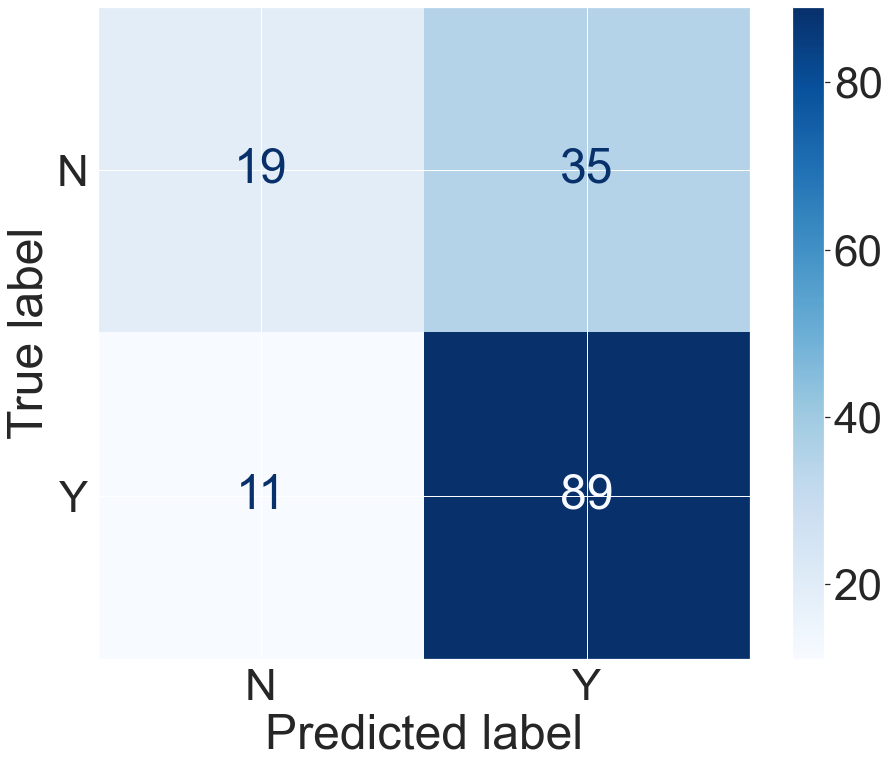

In [79]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
print(f'Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%')


fig, ax = plt.subplots(figsize=(15, 12));
cm = plot_confusion_matrix(rf_load, X_test, y_test, cmap=plt.cm.Blues, ax=ax);
sns.set(font_scale=4.0); 
plt.savefig('img/confusion_matrix.png');

## Test with the Predictor App: api.py

In [ ]:
# Get sample to test on
df_sample = df.sample()
print(df_sample.to_json(orient='records', indent = 4))

[
    {
        "Loan_ID":"LP002197",
        "Gender":"Male",
        "Married":"Yes",
        "Dependents":"2",
        "Education":"Graduate",
        "Self_Employed":"No",
        "ApplicantIncome":5185,
        "CoapplicantIncome":0.0,
        "LoanAmount":155.0,
        "Loan_Amount_Term":360.0,
        "Credit_History":1.0,
        "Property_Area":"Semiurban",
        "Loan_Status":"Y"
    }
]


In [67]:
json_data = {
        
        "Gender":"Male",
        "Married":"Yes",
        "Dependents":"2",
        "Education":"Graduate",
        "Self_Employed":"No",
        "ApplicantIncome":5185,
        "CoapplicantIncome":0.0,
        "LoanAmount":155.0,
        "Loan_Amount_Term":360.0,
        "Credit_History":1.0,
        "Property_Area":"Semiurban"
        
    }

In [68]:
import requests
URL = "http://10.0.0.183:5005/predict"
# sending get request and saving the response as response object 
r = requests.post(url = URL, json = json_data)

In [69]:
print(r.json())

{'Loan Approved: ': "['Y']"}
